In [33]:
import numpy as np
import matplotlib.pyplot as plt

import pywt.data
import sys
import cv2

if '..' not in sys.path:
    sys.path.append('..')



In proposed MDLE-IWT method, 
1. IWT is first appliedto the cover image to obtain four wavelet coefficient sub-bands asembedding regions.
1. The embedding sub-bands order in the algorithm is HL, LH, HH, and LL. 
1. Next, the embedding sub-band is divided into 3×3 non-overlapping blocks
1. MDLE scheme is applied to each block


In [34]:
from itertools import chain, repeat, cycle
from stego import codec
from stego.message import message_to_dec, dec_to_message
from stego.transform.dwt import Iwt


class StegoCoder:
    def __init__(self):
        self.iwt = Iwt('haar', level=3, scale=1)

    def _loop_message(self, message):
        return cycle(message)

    def encode(self, img, message):
        self.iwt.forward(img)
        ll = self.iwt.coefficients[0]
        coefficients = self.iwt.coefficients[-1]

        msg_iterator = iter(self._loop_message(message_to_dec(message)))
        # ll_new = codec.encode_band(ll, msg_iterator)
        # self.iwt.coefficients[0] = ll_new
        coefficients_new = [codec.encode_band(band, msg_iterator) for band in coefficients]


        self.iwt.coefficients[-1] = tuple(coefficients_new)

        return self.iwt.inverse()

    def decode(self, img):
        self.iwt.forward(img)
        ll = self.iwt.coefficients[0]
        coefficients = self.iwt.coefficients[-1]

        extracted_data = []
        # extracted_data += codec.decode_band(ll)
        for band in coefficients:
            extracted_data += codec.decode_band(band)

        return dec_to_message(extracted_data)

## Encoding

In [35]:
from stego import correction_codes, image_coder

secret_message = correction_codes.prepare_message("Functions creating iterators for efficient looping")
original = pywt.data.camera()
stego_coder = StegoCoder()

In [36]:
stego_img = stego_coder.encode(original, secret_message)

## Stego Image

np.allclose(stego_img, stego_from_file)=True


(512, 512)

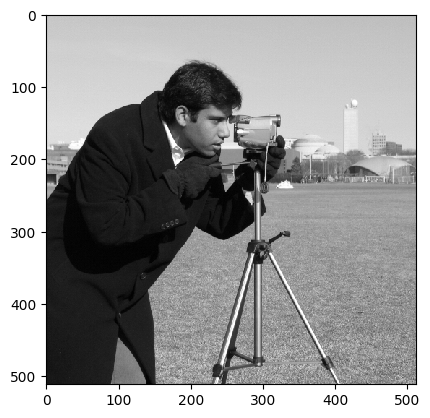

In [37]:
plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
cv2.imwrite("comp.png", stego_img)
img = cv2.imread("comp.png")
stego_from_file, g, b = cv2.split(img)
print(f"{np.allclose(stego_img, stego_from_file)=}")
stego_img = stego_from_file
plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
stego_img.shape


## Extracting

In [38]:
message = stego_coder.decode(stego_img)

In [39]:
def split_list(arr, sublist_size):
    # pad a list
    if len(arr) % sublist_size != 0:
        arr += "" * (sublist_size - (len(arr) % sublist_size))
    return [arr[x:x + sublist_size] for x in range(0, len(arr), sublist_size)]


In [40]:
expressions = split_list(message, 128)

In [41]:
expressions[:3]

["Functions creating iterators for efficient looping\x91\x9b\x9dsá\x035=\x06èüê\x07Ô\x0e'B)T\x01ñê\x85\x89\x8d.vN\x86÷\x91\x95Ñ\\&#W\x0fÝ%+ÊÑ.GT\x84\x16£\x1eNw\x91þ(³b¡\x8d·\x8c\x8fS\x07¡\x1b\x80Ã\x8eí\x8f_\x18x\x18È@?",
 "Functions sreating iterators for efficient looping\x91\x9b\x9dsá\x035=\x06èüê\x07Ô\x0e'B)T\x01ñê\x85\x89\x8d.vN\x86÷A\x95Ñ\\&#W\x0fÝ%+ÊÑ.GT\x84\x16£\x1eNw\x91þ(³b¡\x8d·\x8c\x8fS\x07¡\x1b\x80Ã\x8eí\x8f_\x18x\x18È@?",
 "Functions creating iterators for efficient looping\x91\x9b\x9dsá\x035=\x06èüê\x07Ô\x0e'B)T\x01ñê\x85\x89\x8d.vN\x86÷\x91\x95Ñ\\&#W\x0fÝ%+ÊÑ.GT\x84\x16£\x1eNw¡þ(³b¡\x8d·\x8c\x8fS\x07¡\x1b\x80Ã\x8eí\x8f_\x18x\x18È@?"]

In [42]:
clean_expressions = []
for expr in expressions[:10]:
    clean_expressions.append(correction_codes.decode_message(expr))

In [43]:
print(f"{clean_expressions=}")

clean_expressions=['Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping', 'Functions creating iterators for efficient looping']


## Przeanalizowanie obrazka testowego oraz wyników przekształcenia na poziomie 3 pod kątem różnicy pomiędzy pikselami w obszarze 3x3

In [44]:
from stego.transform.blocking import CropBlocker

original_blocking = CropBlocker(original)
stego_blocking = CropBlocker(stego_img)

In [45]:
original_blocks = original_blocking.divide(block_size=3)
stego_blocks = stego_blocking.divide(block_size=3)

In [46]:
for j, row in enumerate(original_blocks):
    for k, block in enumerate(row):
        s = np.std(block)
        original_blocks[j][k] = (block * 0) + s

orginal_std = original_blocking.stack(original_blocks)


In [47]:
for j, row in enumerate(stego_blocks):
    for k, block in enumerate(row):
        s = np.std(block)
        stego_blocks[j][k] = (block * 0) + s

stego_std = stego_blocking.stack(stego_blocks)

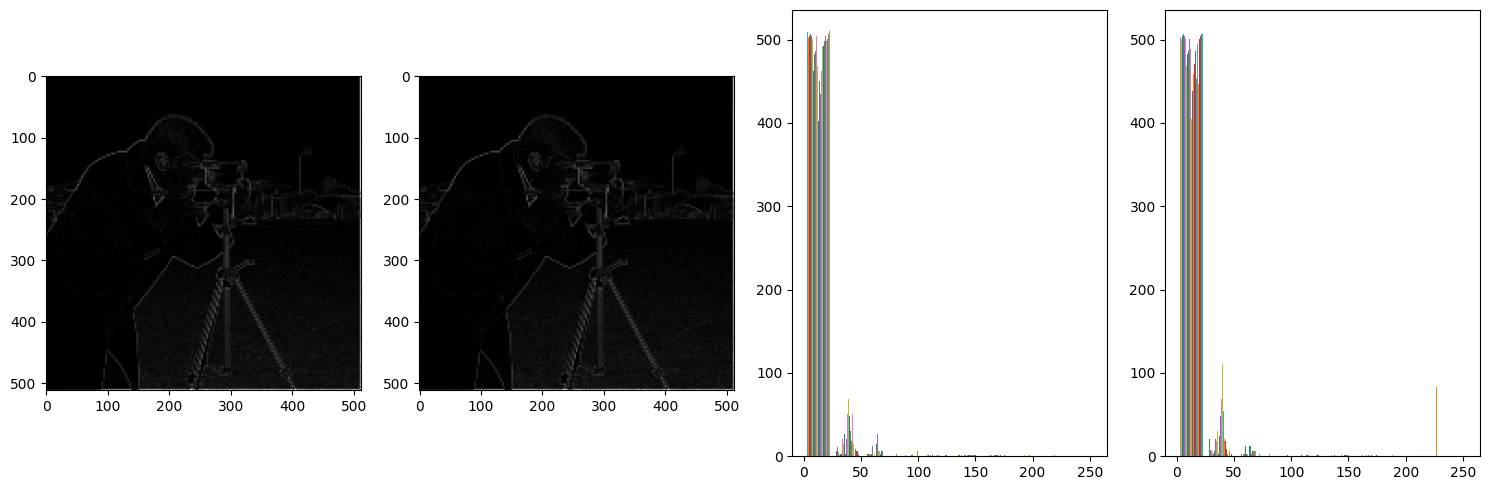

In [49]:
fig = plt.figure(figsize=(15, 5))
for i, a in enumerate([orginal_std, stego_std]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, cmap=plt.cm.gray)
    ax = fig.add_subplot(1, 4, i + 3)
    ax.hist(a)

fig.tight_layout()
plt.show()